# Metric comparison with noisy references

In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

from generate_images import generate_dataset
from helpers import plot_images, normalize_tensor, set_device

device = set_device()

## Generate simulated ARPES-like images

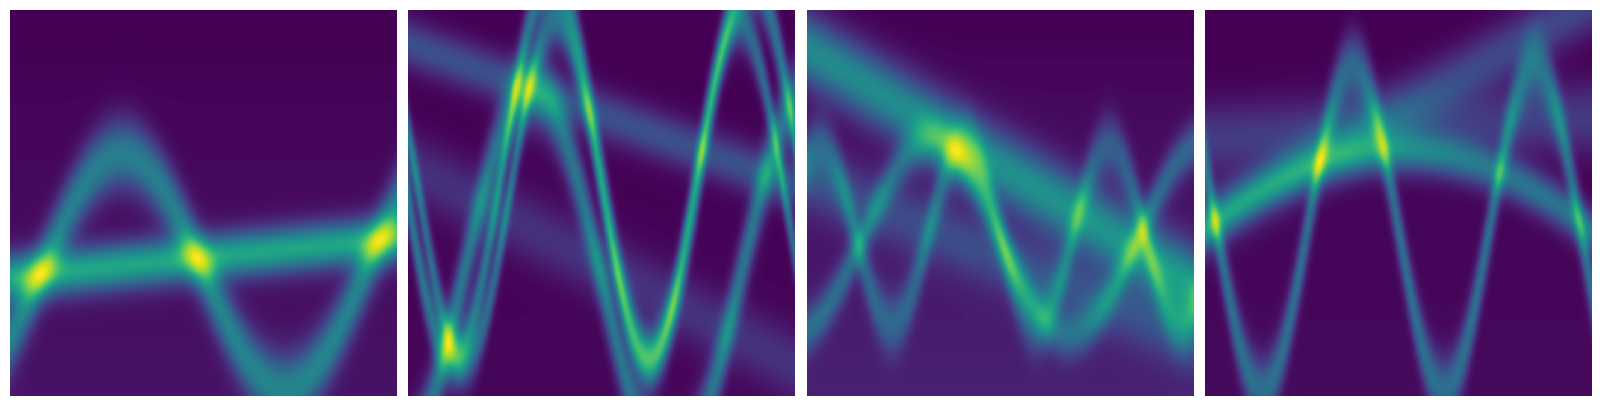

In [2]:
dataset = generate_dataset(n_images=20, device=device)
dataset = normalize_tensor(dataset)

## Simulate Poisson noise of different levels

For simulating Poisson noise, we can scale the pixels in the image to some maximum intensity value (MIV) and this becomes our average lambda for the Poisson process 

For lambda < 1, it produces highly noisy images

In [3]:
from helpers import generate_noise_levels, apply_poisson_noise

# On a log scale, the 20 noise levels are distributed between 10^-2 and 10^3
N_MIV = 20
mivs = generate_noise_levels(lowest=-2, highest=3, n_levels=N_MIV)

This method does a few boilerplate stuff but mainly applies the poisson noise to each image for each max intensity value, also returning the mean intensity value. It also adds the clean image at end of dataset.

In [4]:
max_ivs, mean_ivs, dataset = apply_poisson_noise(mivs, dataset)

/Users/zain/Documents/Masters/Thesis/noisy_ref_analysis/helpers.py:63: UserWarning: The operator 'aten::poisson' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:14.)
  poisson_counts = torch.poisson(scaled_images)         # shape [N_MIV, N_IMG, 1, 256, 256]


In [5]:
dataset.shape

torch.Size([21, 20, 1, 256, 256])

### Example images for two different noise levels

MIV is: 0.20691381
Mean Intensity Values are: [0.02959971 0.03646722 0.04468907 0.03033542]


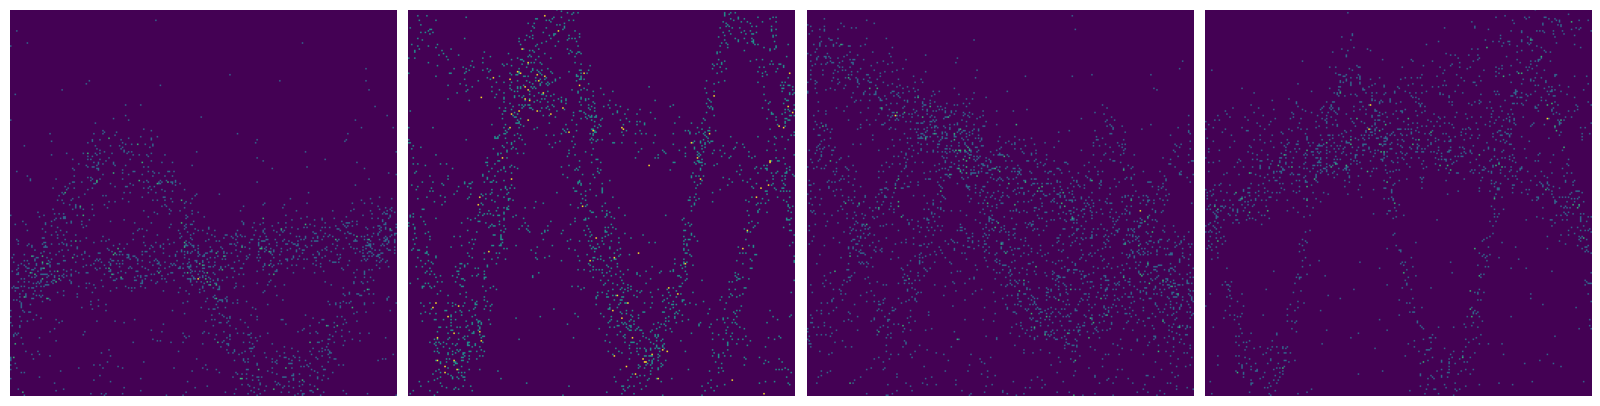

In [6]:
index = 5
print("MIV is:",  max_ivs[index].cpu().numpy())
print("Mean Intensity Values are:",  mean_ivs[index][:4].cpu().numpy())
plot_images(dataset[index].squeeze(1).cpu().numpy())

MIV is: 4.2813325
Mean Intensity Values are: [0.61245894 0.7545572  0.9246786  0.6276816 ]


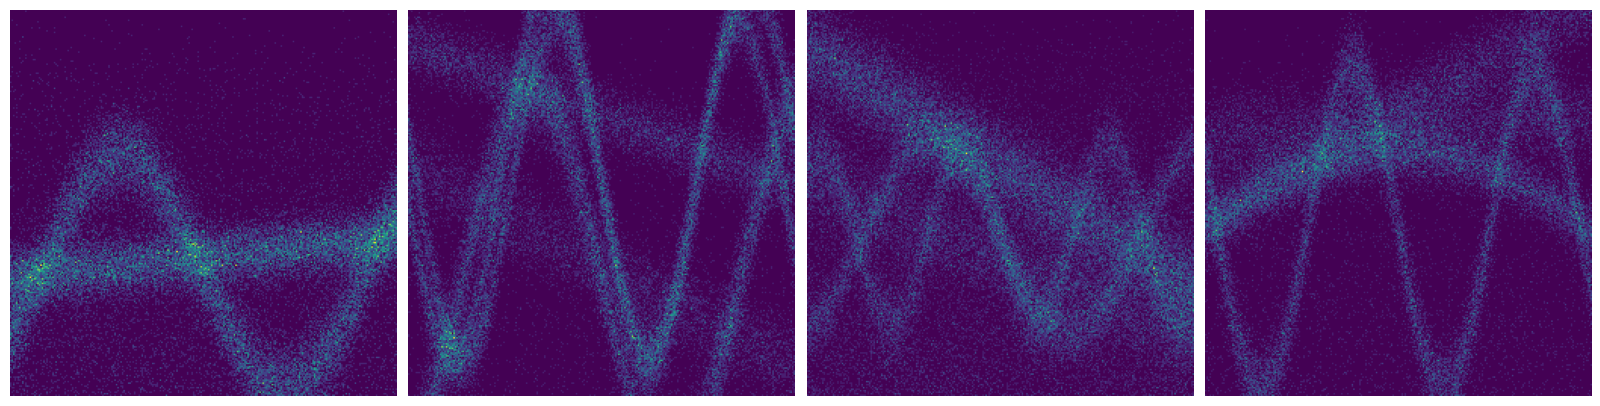

In [7]:
index = 10
print("MIV is:",  max_ivs[index].cpu().numpy())
print("Mean Intensity Values are:",  mean_ivs[index][:4].cpu().numpy())
plot_images(dataset[index].squeeze(1).cpu().numpy())

## Metric comparison

### Now we import some metrics and do comparison of Inputs with varied noise levels:

1. Against clean targets
2. Against noisy targets (higher MIV than input)

In [8]:
from compute_metrics import ComputeMetrics

metrics = ComputeMetrics(device)
metrics.run_analysis(max_ivs, mean_ivs, dataset)
df = metrics.get_df()

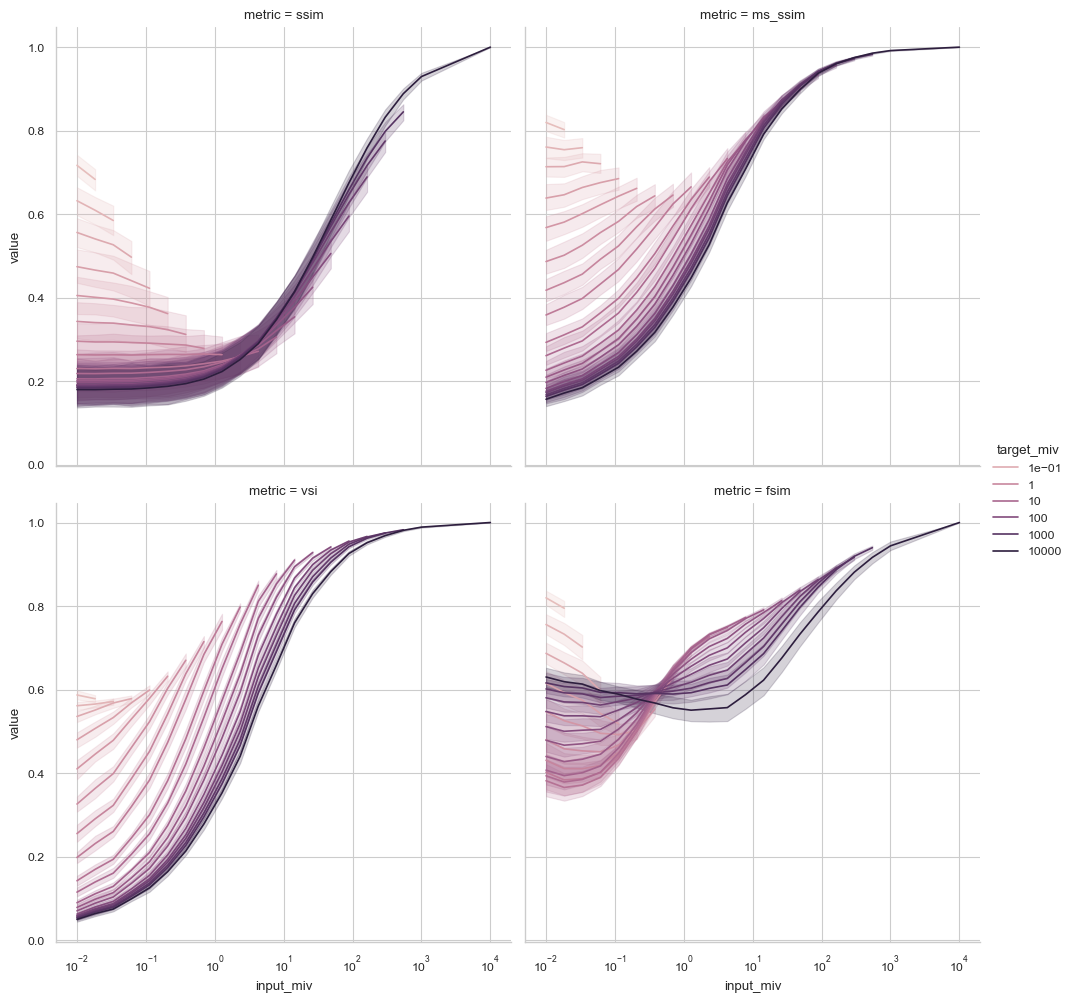

In [12]:
import seaborn as sns
from matplotlib.colors import LogNorm

sns.set_theme()
sns.set_context("paper")
sns.set_style("whitegrid")

g = sns.relplot(data=df, x='input_miv', y='value', hue='target_miv', col='metric', kind='line', col_wrap=2,
                    hue_norm=LogNorm(vmin=df['input_miv'].min(), vmax=df['input_miv'].max()))

g.set(xscale='log')


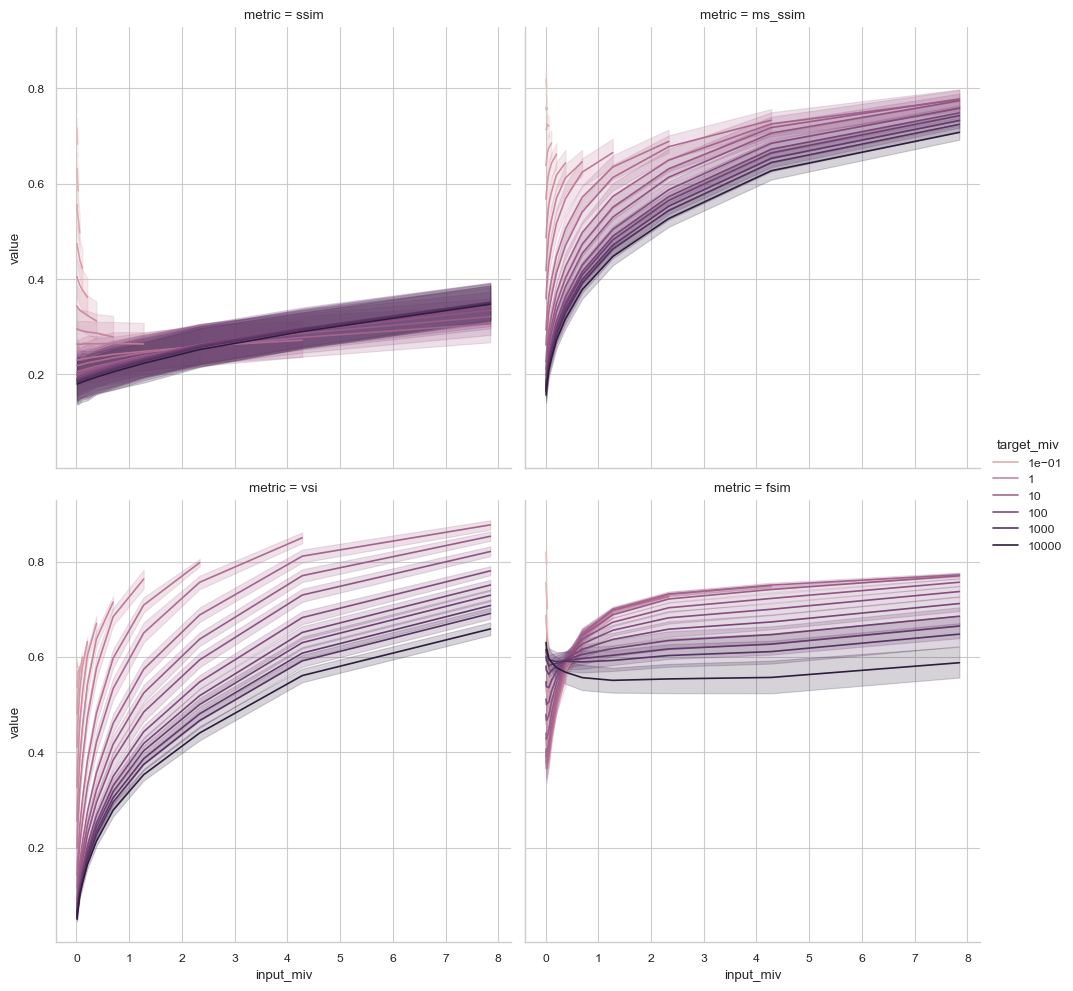

In [13]:
# now plot subset of the data (x-axis) in a normal scale from 0.01 to 10
subset = df[(df['input_miv'] >= 0.01) & (df['input_miv'] <= 10)]
g = sns.relplot(data=subset, x='input_miv', y='value', hue='target_miv', col='metric', kind='line', col_wrap=2,
                                    hue_norm=LogNorm(vmin=df['input_miv'].min(), vmax=df['input_miv'].max()))